In [1]:
#Müşterilerin davranışlarını tahmin etmeye çalışıyoruz

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 26.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=739d7b148367de86d2861803d44868a4706041b2c93e05d419e2e5c9c5b13891
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from google.colab import files
#uploaded=files.upload()



from pyspark import SparkContext
import findspark
findspark.init()
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.sql import SQLContext
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from pandas import DataFrame, Series 
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql import Row
import collections
from pyspark import SparkConf,SparkContext

pd.set_option("display.max_columns", None)

In [5]:
df=pd.read_csv("churn.csv", encoding="ISO-8859-1",)

In [6]:
df.head()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,Cameron Williams,42.0,11066.80,0,7.22,8.0,1
1,1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,1
2,2,Eric Lozano,38.0,12884.75,0,6.67,12.0,1
3,3,Phillip White,42.0,8010.76,0,6.71,10.0,1
4,4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,1


In [7]:
df.tail()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
895,895,Paul Miller,42.0,12800.82,1,3.62,8.0,0
896,896,Natalie Hodges,52.0,9893.92,0,6.91,7.0,0
897,897,Ana Smith,45.0,12056.18,0,5.46,4.0,0
898,898,Justin Leonard,51.0,6517.93,1,5.47,10.0,0
899,899,Joseph Williams,39.0,9315.60,1,5.02,10.0,0


In [12]:
df.sample()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
474,474,Sally Smith,45.0,11575.84,0,5.51,9.0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       900 non-null    int64  
 1   Names            900 non-null    object 
 2   Age              900 non-null    float64
 3   Total_Purchase   900 non-null    float64
 4   Account_Manager  900 non-null    int64  
 5   Years            900 non-null    float64
 6   Num_Sites        900 non-null    float64
 7   Churn            900 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 56.4+ KB


In [14]:
df.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of      Unnamed: 0  Names    Age  Total_Purchase  Account_Manager  Years  \
0         False  False  False           False            False  False   
1         False  False  False           False            False  False   
2         False  False  False           False            False  False   
3         False  False  False           False            False  False   
4         False  False  False           False            False  False   
..          ...    ...    ...             ...              ...    ...   
895       False  False  False           False            False  False   
896       False  False  False           False            False  False   
897       False  False  False           False            False  False   
898       False  False  False           False            False  False   
899       False  False  False           False            False  False   

     Num_Sites  Churn  
0        False  False  
1        Fals

In [15]:
df.corr()

,Unnamed: 0,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
Unnamed: 0,1.000000,-0.037801,-0.018938,-0.067247,-0.143873,-0.378287,-0.645498
Age,-0.037801,1.000000,-0.037208,-0.014749,0.005625,-0.006070,0.085926
Total_Purchase,-0.018938,-0.037208,1.000000,0.015856,-0.005623,-0.003390,0.024031
Account_Manager,-0.067247,-0.014749,0.015856,1.000000,0.022930,0.033401,0.070611
Years,-0.143873,0.005625,-0.005623,0.022930,1.000000,0.051642,0.214329
Num_Sites,-0.378287,-0.006070,-0.003390,0.033401,0.051642,1.000000,0.525398
Churn,-0.645498,0.085926,0.024031,0.070611,0.214329,0.525398,1.000000


In [16]:
df.describe()

,Unnamed: 0,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,449.500000,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,259.951919,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,0.000000,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,224.750000,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,449.500000,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,674.250000,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,899.000000,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [10]:
df.shape

(900, 8)

In [18]:
df.columns

Index(['Unnamed: 0', 'Names', 'Age', 'Total_Purchase', 'Account_Manager',
       'Years', 'Num_Sites', 'Churn'],
      dtype='object')

In [19]:
df["Names"].nunique()

899

In [20]:
df["Age"].unique()

array([42., 41., 38., 37., 48., 44., 32., 43., 40., 30., 45., 53., 46.,
       56., 35., 55., 54., 36., 50., 58., 49., 47., 52., 39., 51., 29.,
       34., 26., 31., 33., 65., 28., 60., 25., 27., 22.])

In [21]:
df["Total_Purchase"].unique()

array([11066.8 , 11916.22, 12884.75,  8010.76,  9191.58, 10356.02,
       11331.58,  9885.12, 14062.6 ,  8066.94, 11575.37,  8771.02,
        8988.67,  8283.32,  6569.87, 10494.82,  8213.41, 11226.88,
        5515.09,  8046.4 ,  9771.22, 12217.95,  9381.12, 10474.94,
       11158.5 ,  8207.1 , 12403.81, 10041.13, 12721.55,  8284.89,
       10661.48, 10793.11,  9322.44,  9814.22, 11740.  , 14383.36,
       11887.39, 10367.08,  8198.06,  7777.37, 11699.26, 16838.94,
       10484.33,  8736.06, 10850.78,  8601.01, 11170.06, 11185.62,
        9793.42, 12524.68, 12682.9 , 14036.28, 10179.92, 12772.72,
       12122.19,  9922.3 ,  4771.65, 10827.96,  8642.01,  6749.49,
        6447.99, 11091.21,  5024.52, 12376.37, 12458.8 ,  7222.35,
       11758.69,  8772.  ,  7351.38,  7960.64, 13365.66,  8617.98,
       11849.13, 11145.95,  9577.42, 10110.4 ,  8024.08,  8563.24,
        9403.58, 12520.53, 13655.59, 12680.46,  8429.65, 11424.  ,
       13725.55,  7396.1 ,  8100.43, 10400.88,  8625.96,  5192

In [22]:
df["Num_Sites"].unique()

array([ 8., 11., 12., 10.,  9., 13., 14.,  7.,  6.,  5.,  4.,  3.])

In [23]:
df["Churn"].unique()

array([1, 0])

In [24]:
df["Num_Sites"]=df["Num_Sites"].astype(float)
df["Years"]=df["Years"].astype(float)
df["Total_Purchase"]=df["Total_Purchase"].astype(float)
df["Age"]=df["Age"].astype(float)
df["Account_Manager"]=df["Account_Manager"].astype(float)
df["Churn"]=df["Churn"].astype(float)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       900 non-null    int64  
 1   Names            900 non-null    object 
 2   Age              900 non-null    float64
 3   Total_Purchase   900 non-null    float64
 4   Account_Manager  900 non-null    float64
 5   Years            900 non-null    float64
 6   Num_Sites        900 non-null    float64
 7   Churn            900 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 56.4+ KB


In [26]:
df.sample(5)

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
719,719,Molly Perez,36.0,11079.61,1.0,4.12,9.0,0.0
222,222,Emily Little,35.0,6683.82,1.0,7.82,7.0,0.0
467,467,Holly Flores,47.0,15878.11,1.0,2.05,8.0,0.0
73,73,Sandra Williams,37.0,11145.95,1.0,5.87,11.0,1.0
574,574,Mallory Powell,48.0,9921.89,0.0,3.73,9.0,0.0


In [27]:
del df["Names"]

In [29]:
df.sample()

,Unnamed: 0,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
383,383,45.0,11486.53,1.0,5.5,7.0,0.0


In [30]:
df=df.drop(["Unnamed: 0" ], axis=1)

In [31]:
df.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0.0,7.22,8.0,1.0
1,41.0,11916.22,0.0,6.50,11.0,1.0
2,38.0,12884.75,0.0,6.67,12.0,1.0
3,42.0,8010.76,0.0,6.71,10.0,1.0
4,37.0,9191.58,0.0,5.56,9.0,1.0


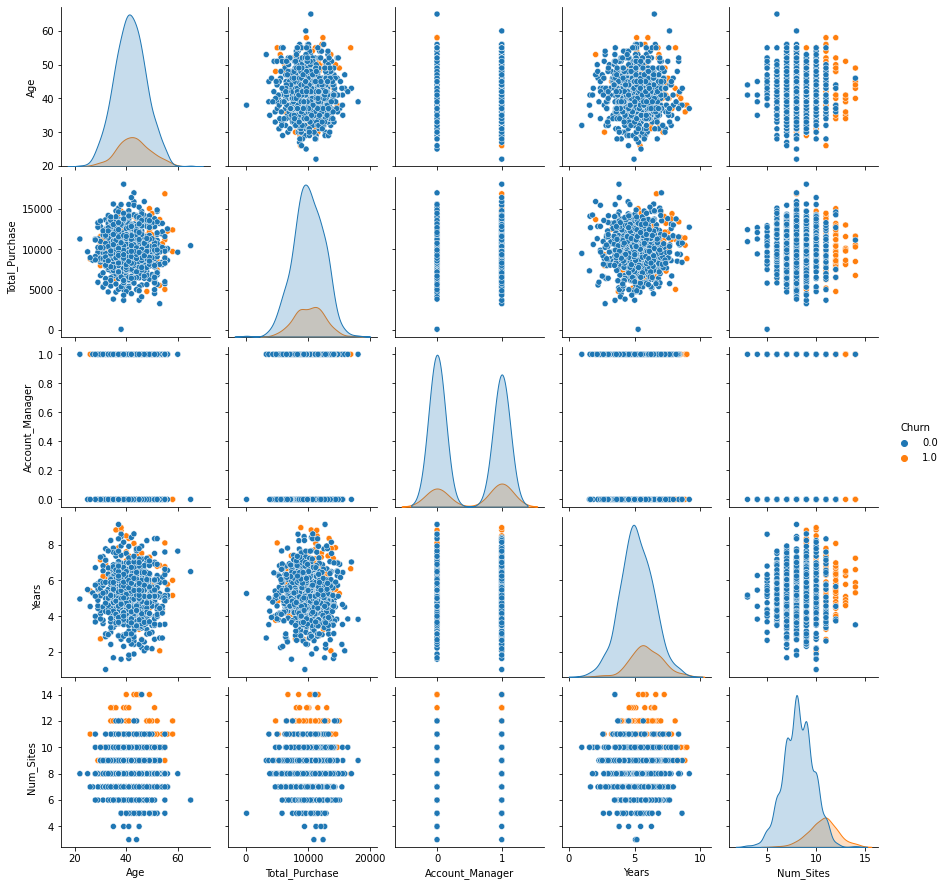

In [32]:
sns.pairplot(df,hue="Churn");

In [33]:
from __future__ import print_function

In [34]:
spark=SparkSession.builder.getOrCreate()

In [35]:
inputlines=df = spark.read.options(header = True, inferSchema = True).csv("churn.csv")

In [36]:
inputlines

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [37]:
df=inputlines.rdd.map(lambda x: x.split(","))

In [38]:
colnames=['Age','Total_Purchase','Account_Manager','Years','Num_Sites','Churn']

In [39]:
df1=inputlines

In [40]:
from  pyspark.ml.feature import VectorAssembler


In [41]:
vecAssembler = VectorAssembler(inputCols=['Age','Total_Purchase','Account_Manager','Years','Num_Sites'], outputCol="features")
df1= vecAssembler.transform(df1)
df1

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int, features: vector]

In [42]:
df1 = df1.drop("index", 'Age','Total_Purchase','Account_Manager','Years','Num_Sites')
df1

DataFrame[_c0: int, Names: string, Churn: int, features: vector]

In [43]:
df1 = df1.withColumnRenamed("Churn", "label")
df1

DataFrame[_c0: int, Names: string, label: int, features: vector]

In [44]:
trainTest=df1.randomSplit([0.5,0.5])
trainingDF=trainTest[0]
testDF=trainTest[1]

In [45]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [46]:
gbt=GBTClassifier(featuresCol='features',maxIter=10)

In [47]:
gbt = gbt.fit(trainingDF)

In [48]:
predictions = gbt.transform(testDF)
predictions.show()

+---+-------------------+-----+--------------------+--------------------+--------------------+----------+
|_c0|              Names|label|            features|       rawPrediction|         probability|prediction|
+---+-------------------+-----+--------------------+--------------------+--------------------+----------+
|  0|   Cameron Williams|    1|[42.0,11066.8,0.0...|[1.32242118007330...|[0.93369238968806...|       0.0|
|  1|      Kevin Mueller|    1|[41.0,11916.22,0....|[-1.2579420271716...|[0.07475212363631...|       1.0|
|  3|      Phillip White|    1|[42.0,8010.76,0.0...|[0.44160187358599...|[0.70748567604325...|       0.0|
|  4|     Cynthia Norton|    1|[37.0,9191.58,0.0...|[1.28051056004003...|[0.92831044317327...|       0.0|
|  5|   Jessica Williams|    1|[48.0,10356.02,0....|[1.13208847225626...|[0.90586641368792...|       0.0|
|  6|        Eric Butler|    1|[44.0,11331.58,1....|[-0.5636601199960...|[0.24465598010870...|       1.0|
|  7|      Zachary Walsh|    1|[32.0,9885.12,1